In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import xarray as xr
from skyfield.sgp4lib import EarthSatellite
import skyfield.api

import urllib.request
import http.cookiejar

import matplotlib.cm
import matplotlib.colors

c = 299792458

In [2]:
def new_figure():
    plt.figure(figsize = (14, 10), facecolor='w')

def set_axis_options():
    plt.gca().xaxis.set_major_locator(mdates.DayLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.grid()

def set_axis_labels():
    plt.xlabel('UTC time')
    plt.ylabel('Doppler (ppb)')

def set_legend():
    plt.legend([f'EA4GPZ measurements at {frequency_MHz:d}MHz',\
            'TLEs'])

In [3]:
dataset = 'ppb.nc'
dataset = 'ppb_2019.nc'
dataset = 'ppb_2019_11205.nc'
ppb_ea4gpz = xr.open_dataset(dataset)

if dataset == 'ppb.nc':
    frequency_MHz = 10706
    # filter out some invalid measurements
    ppb_ea4gpz['ppb'][ppb_ea4gpz['ppb'] > -20] = np.nan
    ppb_ea4gpz['ppb'][ppb_ea4gpz['ppb'] < -40] = np.nan

    # fix spurious measurement
    ppb_ea4gpz['ppb'][(ppb_ea4gpz['ppb'] > -33) & (ppb_ea4gpz.coords['time'] < np.datetime64('2018-11-27')) ]= np.nan
elif dataset == 'ppb_2019.nc':
    frequency_MHz = 10706
    ppb_ea4gpz['ppb'][ppb_ea4gpz['ppb'] > -20] = np.nan
    ppb_ea4gpz['ppb'][ppb_ea4gpz['ppb'] < -30] = np.nan
elif dataset == 'ppb_2019_11205.nc':
    frequency_MHz = 11205
    ppb_ea4gpz['ppb'][ppb_ea4gpz['ppb'] > -30] = np.nan
    ppb_ea4gpz['ppb'][ppb_ea4gpz['ppb'] < -40] = np.nan

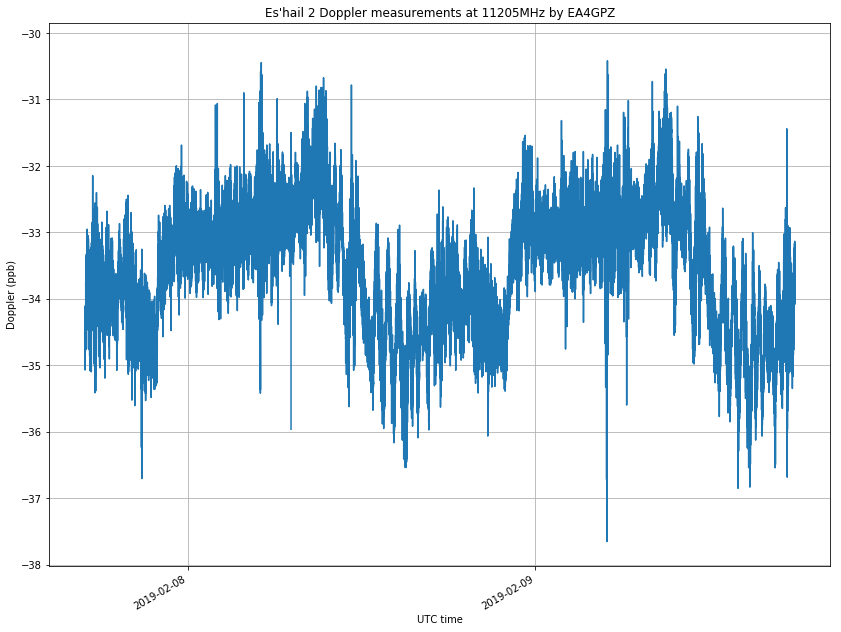

In [4]:
new_figure()
ppb_ea4gpz['ppb'].plot()
set_axis_options()
plt.title(f'Es\'hail 2 Doppler measurements at {frequency_MHz}MHz by EA4GPZ')
set_axis_labels()

In [5]:
def opener_spacetrack(username, password):
    # todo: clean login info from ipynb file
    cj = http.cookiejar.CookieJar()
    opener = urllib.request.build_opener(urllib.request.HTTPCookieProcessor(cj))
    auth_url = 'https://www.space-track.org/ajaxauth/login/'
    auth_data = urllib.parse.urlencode({'identity' : username, 'password' : password}).encode('utf-8')
    auth_req = urllib.request.Request(auth_url, auth_data)
    r = opener.open(auth_req)
    return opener

def get_tles(opener):
    url = 'https://www.space-track.org/basicspacedata/query/class/tle/EPOCH/%3E2018-11-20/NORAD_CAT_ID/43700/orderby/EPOCH%20ASC/format/tle'
    r = opener.open(url)
    tle_lines = r.read().decode('ascii').split('\r\n')
    return [EarthSatellite(*x) for x in zip(tle_lines[::2], tle_lines[1::2])]

In [6]:
with open('../spacetrack_auth', 'r') as f:
    username, password = f.read().split('\n')[:2]
    opener = opener_spacetrack(username, password)

tles = get_tles(opener)

In [7]:
ts = skyfield.api.load.timescale()

In [8]:
doppler_times = np.arange(ppb_ea4gpz.coords['time'].values[0], ppb_ea4gpz.coords['time'].values[-1], np.timedelta64(1, 'm'))
timestamps = (doppler_times - np.datetime64('1970-01-01T00:00:00'))/np.timedelta64(1, 's')
times = ts.utc([datetime.datetime.utcfromtimestamp(t).replace(tzinfo = skyfield.api.utc) for t in timestamps])

In [9]:
cuts = [None] * (len(tles)+1)
cuts[0] = 0
for j in range(len(tles) - 1):
    try:
        cut = np.where(np.abs(times-tles[j].epoch) - np.abs(times-tles[j+1].epoch) > 0)[0][0]
    except IndexError:
        cut = 0
    cuts[j+1] = max(cut, cuts[j])
slices = [slice(a,b) for a,b in zip(cuts[:-1], cuts[1:])]

In [10]:
ea4gpz = skyfield.api.Topos(latitude = 40.595865, longitude = -3.699069, elevation_m = 800)

In [11]:
rvs = [(eshail2 - ea4gpz).at(times[sl]) for eshail2,sl in zip(tles, slices) if len(times[sl])]

In [12]:
dtimes = np.concatenate([doppler_times[sl][:-1] for eshail2,sl in zip(tles, slices) if len(times[sl])])

In [13]:
doppler_data = -np.concatenate([np.diff(rv.distance().km) for rv in rvs])/60*1e12/c
doppler_ppb = xr.DataArray(doppler_data,\
                           coords = {'time' : dtimes},\
                           dims=('time'))

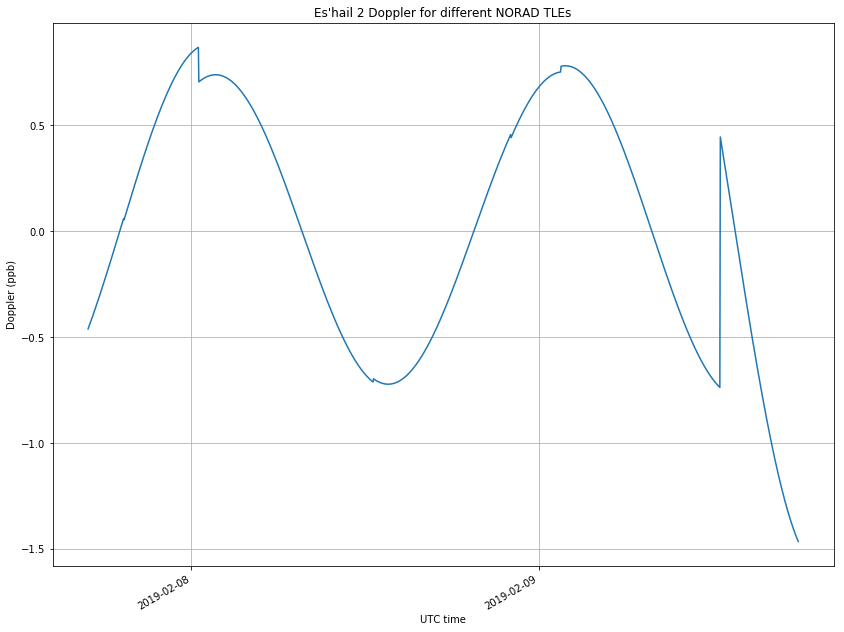

In [14]:
new_figure()
doppler_ppb.plot()
set_axis_options()
plt.title('Es\'hail 2 Doppler for different NORAD TLEs')
set_axis_labels()

In [15]:
measurements = (ppb_ea4gpz['ppb']-ppb_ea4gpz['ppb'].mean()).resample(time = '10min').mean()

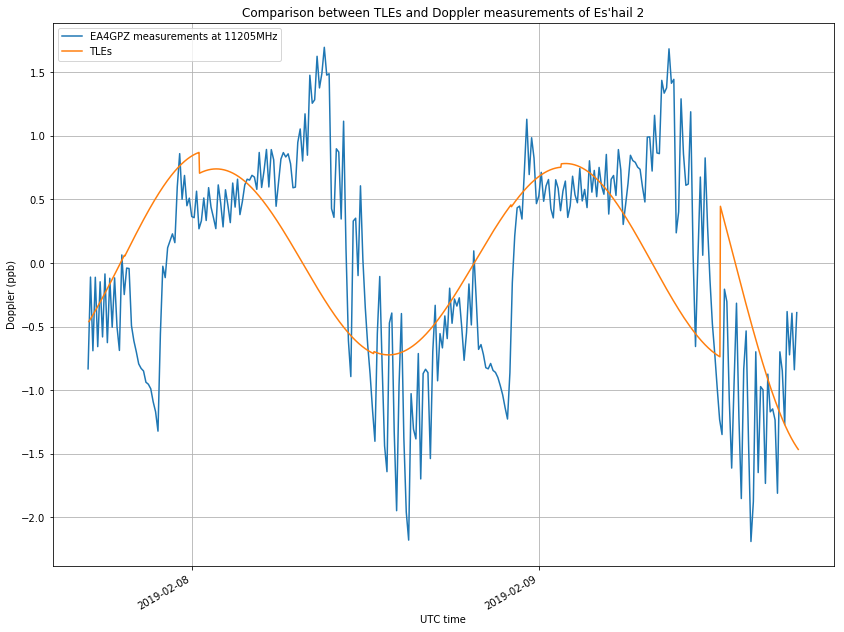

In [16]:
new_figure()
measurements.plot()
doppler_ppb.plot()
set_axis_options()
set_legend()
set_axis_labels()
plt.title('Comparison between TLEs and Doppler measurements of Es\'hail 2');

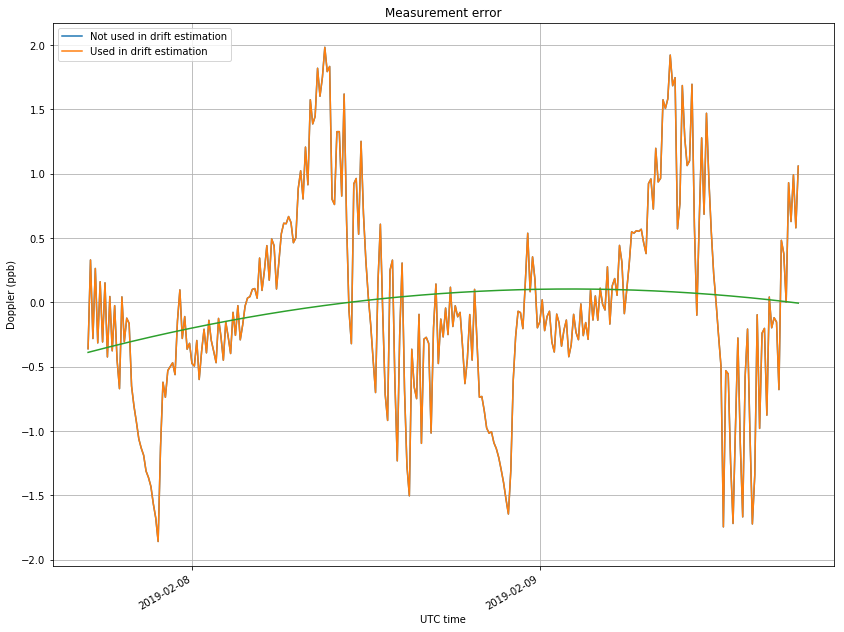

In [17]:
new_figure()
error = (measurements-doppler_ppb.interp(time = measurements.coords['time'], kwargs = {'fill_value' : 'extrapolate'}))
#error_sel = xr.concat((error.sel(time = slice('2018-11-28 21:00', '2018-12-02 20:44:16')),
#                       error.sel(time = slice('2018-12-08 00:00', '2018-12-09 23:56:04'))),
#                      dim = 'time')
error_sel = error.dropna('time')

error_times = error.coords['time'].values.astype('datetime64[s]').astype('float')
error_times_sel = error_sel.coords['time'].values.astype('datetime64[s]').astype('float')
p_error = np.polyfit(error_times_sel, error_sel.values, 2)
error_model = xr.DataArray(np.polyval(p_error, error_times),
                           coords = {'time' : measurements.coords['time']},
                           dims = ('time'))

error.plot()
error_sel.plot()
error_model.plot()
set_axis_options()
set_axis_labels()
plt.title('Measurement error')
plt.legend(['Not used in drift estimation', 'Used in drift estimation']);

Frequency drift in 1/s

In [18]:
p_error[1] * 1e-9

1.0629932620999153e-10

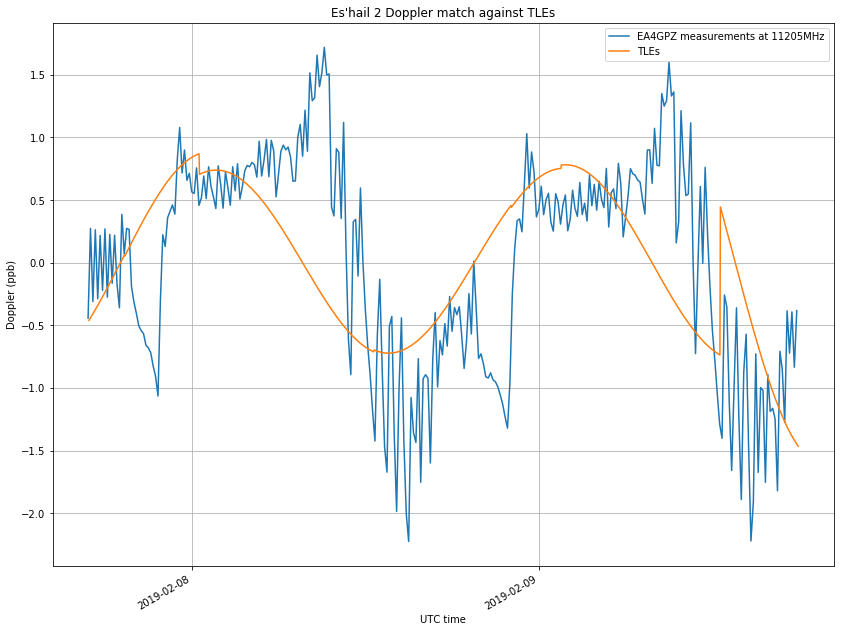

In [19]:
new_figure()
(measurements - error_model).plot()
doppler_ppb.plot()
set_axis_options()
set_axis_labels()
set_legend()
plt.title('Es\'hail 2 Doppler match against TLEs');

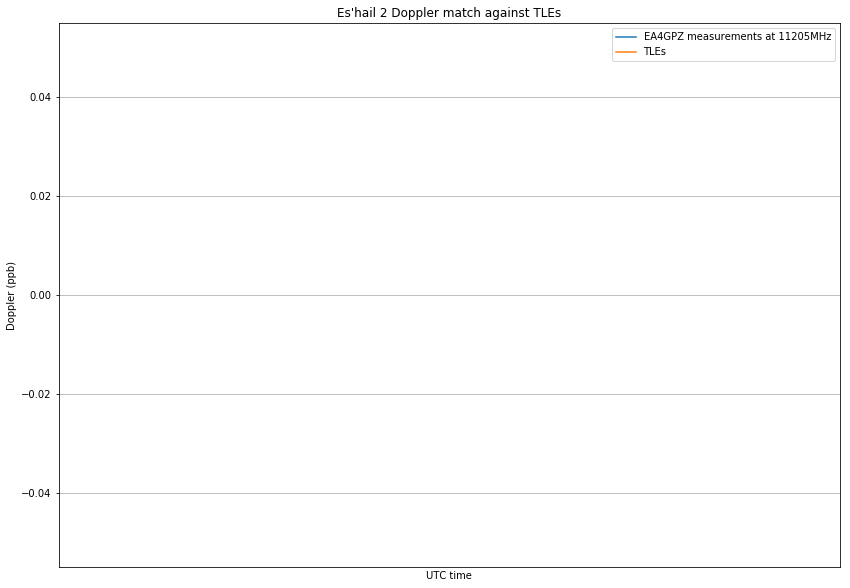

In [20]:
new_figure()
tsel = slice('2018-12-30T15:00','2019-01-10')
(measurements - error_model).sel(time=tsel).plot()
doppler_ppb.sel(time=tsel).plot()
set_axis_options()
set_axis_labels()
set_legend()
plt.title('Es\'hail 2 Doppler match against TLEs');

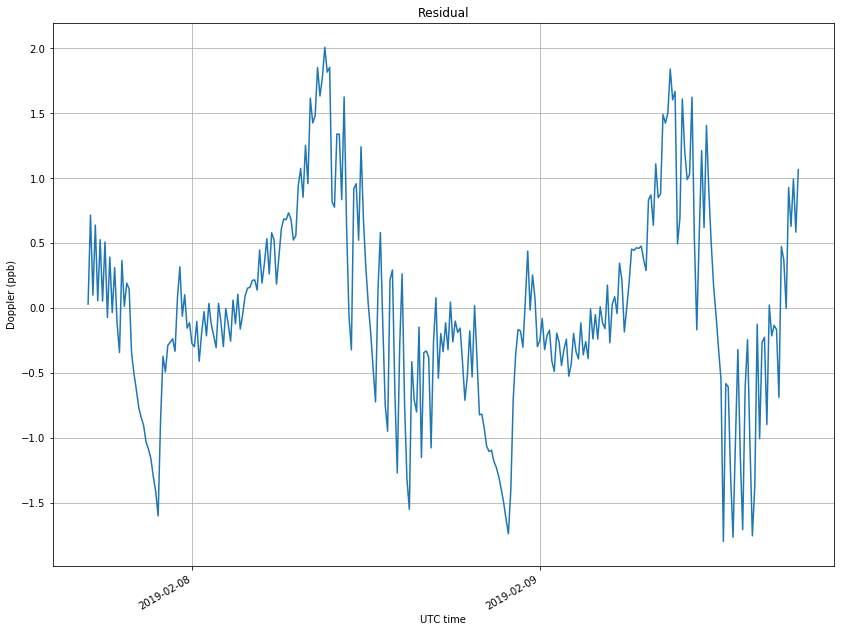

In [21]:
new_figure()
residual = (measurements - error_model - doppler_ppb.interp(time = measurements.coords['time'], kwargs = {'fill_value' : 'extrapolate'}))
residual.plot()
set_axis_options()
set_axis_labels()
plt.title('Residual');

In [22]:
subpoints = [eshail2.at(times[sl]).subpoint() for eshail2,sl in zip(tles,slices) if len(times[sl])]

In [23]:
longitude = np.concatenate([sp.longitude.degrees for sp in subpoints])
latitude = np.concatenate([sp.latitude.degrees for sp in subpoints])
elevation = np.concatenate([sp.elevation.km for sp in subpoints])

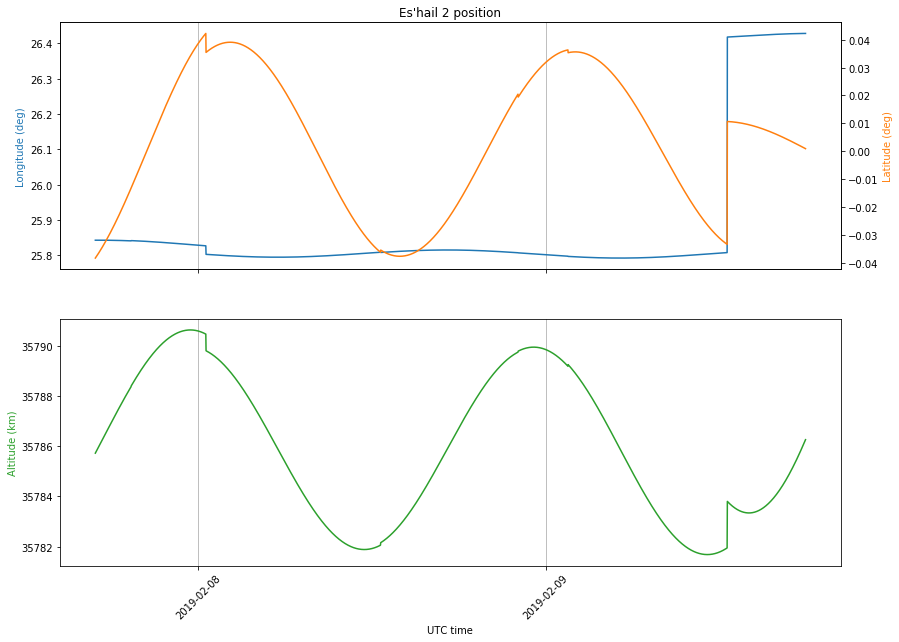

In [24]:
fig, axs = plt.subplots(2, figsize = (14, 10), facecolor = 'w')
ax1 = axs[0]
ax2 = ax1.twinx()
ax3 = axs[1]
ax1.plot(doppler_times, longitude, color = 'C0')
ax2.plot(doppler_times, latitude, color = 'C1')
ax3.plot(doppler_times, elevation, color = 'C2')
ax1.set_ylabel('Longitude (deg)', color = 'C0')
ax2.set_ylabel('Latitude (deg)', color = 'C1')
ax3.set_ylabel('Altitude (km)', color = 'C2')
ax1.set_title('Es\'hail 2 position')
for ax in axs:
    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter(''))
    ax.grid(axis = 'x')
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax3.tick_params('x', rotation = 45)
ax3.set_xlabel('UTC time');

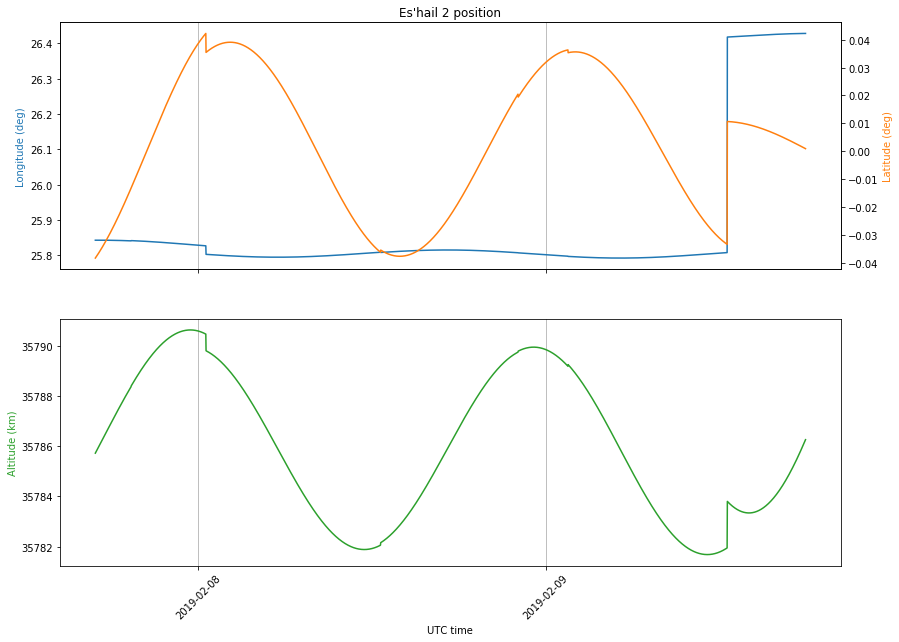

In [25]:
fig, axs = plt.subplots(2, figsize = (14, 10), facecolor = 'w')
ax1 = axs[0]
ax2 = ax1.twinx()
ax3 = axs[1]
tsel = doppler_times > np.datetime64('2018-12-30T15:00')
ax1.plot(doppler_times[tsel], longitude[tsel], color = 'C0')
ax2.plot(doppler_times[tsel], latitude[tsel], color = 'C1')
ax3.plot(doppler_times[tsel], elevation[tsel], color = 'C2')
ax1.set_ylabel('Longitude (deg)', color = 'C0')
ax2.set_ylabel('Latitude (deg)', color = 'C1')
ax3.set_ylabel('Altitude (km)', color = 'C2')
ax1.set_title('Es\'hail 2 position')
for ax in axs:
    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter(''))
    ax.grid(axis = 'x')
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax3.tick_params('x', rotation = 45)
ax3.set_xlabel('UTC time');